In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
import pickle

pd.options.display.max_columns = 100

In [2]:
train_month_df = pd.read_excel('data/train.xlsx', sheet_name='Monthly').drop(0)
train_quart_df = pd.read_excel('data/train.xlsx', sheet_name='Quarterly').drop(0)

train_month_df['month'] = [int(x[-2:]) for x in train_month_df['Unnamed: 0'].tolist()]
train_month_df['year'] = [int(x[:4]) for x in train_month_df['Unnamed: 0'].tolist()]

train_quart_df['month'] = [int(x[-2:]) for x in train_quart_df['Unnamed: 0'].tolist()]
train_quart_df['year'] = [int(x[:4]) for x in train_quart_df['Unnamed: 0'].tolist()]

train_month_df['year'] -= train_month_df['year'].min()
train_quart_df['year'] -= train_quart_df['year'].min()

train_month_df['month_num'] = train_month_df['month'] + train_month_df['year'] * 12
train_quart_df['month_num'] = train_quart_df['month'] + train_quart_df['year'] * 12

train_month_df.drop('Unnamed: 0', axis=1, inplace=True)
train_quart_df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
cluster_data = train_month_df.copy()
for clm in cluster_data.columns.to_list()[:-3]:
    cluster_data[clm] = (cluster_data[clm].values - np.mean(cluster_data[clm])) / np.std(cluster_data[clm])

In [4]:
cols = cluster_data.columns.to_list()[:-3]
cluster_table = None
for i in range(len(cluster_data.columns.to_list()[:-3])):
    
    values = cluster_data[cols[i]].dropna().tolist()
    new = [abs(values[x]-values[x-1]) for x in range(1, len(values))]
    
    all_features = cluster_data[cols[i]].agg(['mean'])
    all_features['mean_diff'] = np.mean(new)
    all_features['median_diff'] = np.median(new)
    all_features['std_diff'] = np.std(new)
    all_features['max_diff'] = np.max(new)
    all_features['min_diff'] = np.min(new)
    if i == 0:
        cluster_table = pd.DataFrame(all_features).transpose()
    else:
        cluster_table = pd.concat([cluster_table, pd.DataFrame(all_features).transpose()])

from sklearn import datasets
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5)
model.fit(cluster_table)

all_predictions = model.predict(cluster_table)

cluster_table['class'] = all_predictions
cluster_table

,mean,mean_diff,median_diff,std_diff,max_diff,min_diff,class
"Диффузный индекс цен на выпускаемую продукцию, ожидаемые изменения",4.554761e-16,0.482861,0.365684,0.343066,1.828422,0.000000,0
"Диффузный индекс цен на покупаемую продукцию, ожидаемые изменения",6.376666e-16,0.526631,0.500784,0.400062,1.836207,0.000000,0
"Диффузный индекс заработной платы, ожидаемые изменения",-9.109522e-17,0.378085,0.317919,0.326580,1.801542,0.000000,0
"Диффузный индекс занятости, ожидаемые изменения",-4.953303e-16,0.525060,0.500313,0.388601,1.834481,0.000000,0
"Диффузный индекс выпуска, ожидаемые изменения",4.554761e-17,0.523242,0.366980,0.451647,2.293624,0.000000,1
...,...,...,...,...,...,...,...
"Ставка по краткосрочным кредитам, фирмы",-3.245267e-16,0.192338,0.143057,0.245781,2.636987,0.001248,1
"Ставка по долгосрочным кредитам, фирмы",4.327023e-16,0.339266,0.207838,0.372596,1.778292,0.001667,0
"Краткосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб",9.022697e-15,0.043272,0.037893,0.030960,0.207339,0.001434,2
"Долгосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб",-3.189756e-15,0.024509,0.021077,0.019884,0.128999,0.000101,2


In [5]:
cluster_data = train_quart_df.copy()
for clm in cluster_data.columns.to_list()[:-3]:
    cluster_data[clm] = (cluster_data[clm].values - np.mean(cluster_data[clm])) / np.std(cluster_data[clm])

cols = cluster_data.columns.to_list()[:-3]
cluster_table = None
for i in range(len(cluster_data.columns.to_list()[:-3])):
    values = cluster_data[cols[i]].dropna().tolist()
    new = [abs(values[x]-values[x-1]) for x in range(1, len(values))]
    all_features = cluster_data[cols[i]].agg(['mean'])
    all_features['mean_diff'] = np.mean(new)
    all_features['median_diff'] = np.median(new)
    all_features['std_diff'] = np.std(new)
    all_features['max_diff'] = np.max(new)
    all_features['min_diff'] = np.min(new)
    if i == 0:
        cluster_table = pd.DataFrame(all_features).transpose()
    else:
        cluster_table = pd.concat([cluster_table, pd.DataFrame(all_features).transpose()])

from sklearn import datasets
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4)
model.fit(cluster_table)
all_predictions = model.predict(cluster_table)

print(all_predictions)
cluster_table['class'] = all_predictions
first = cluster_table[cluster_table['class'] == 4].index.to_list()

[0 3 1 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 2 2 0 1 3 0 3 2 1 1 1 3 3 3
 1 1]


Пример класса

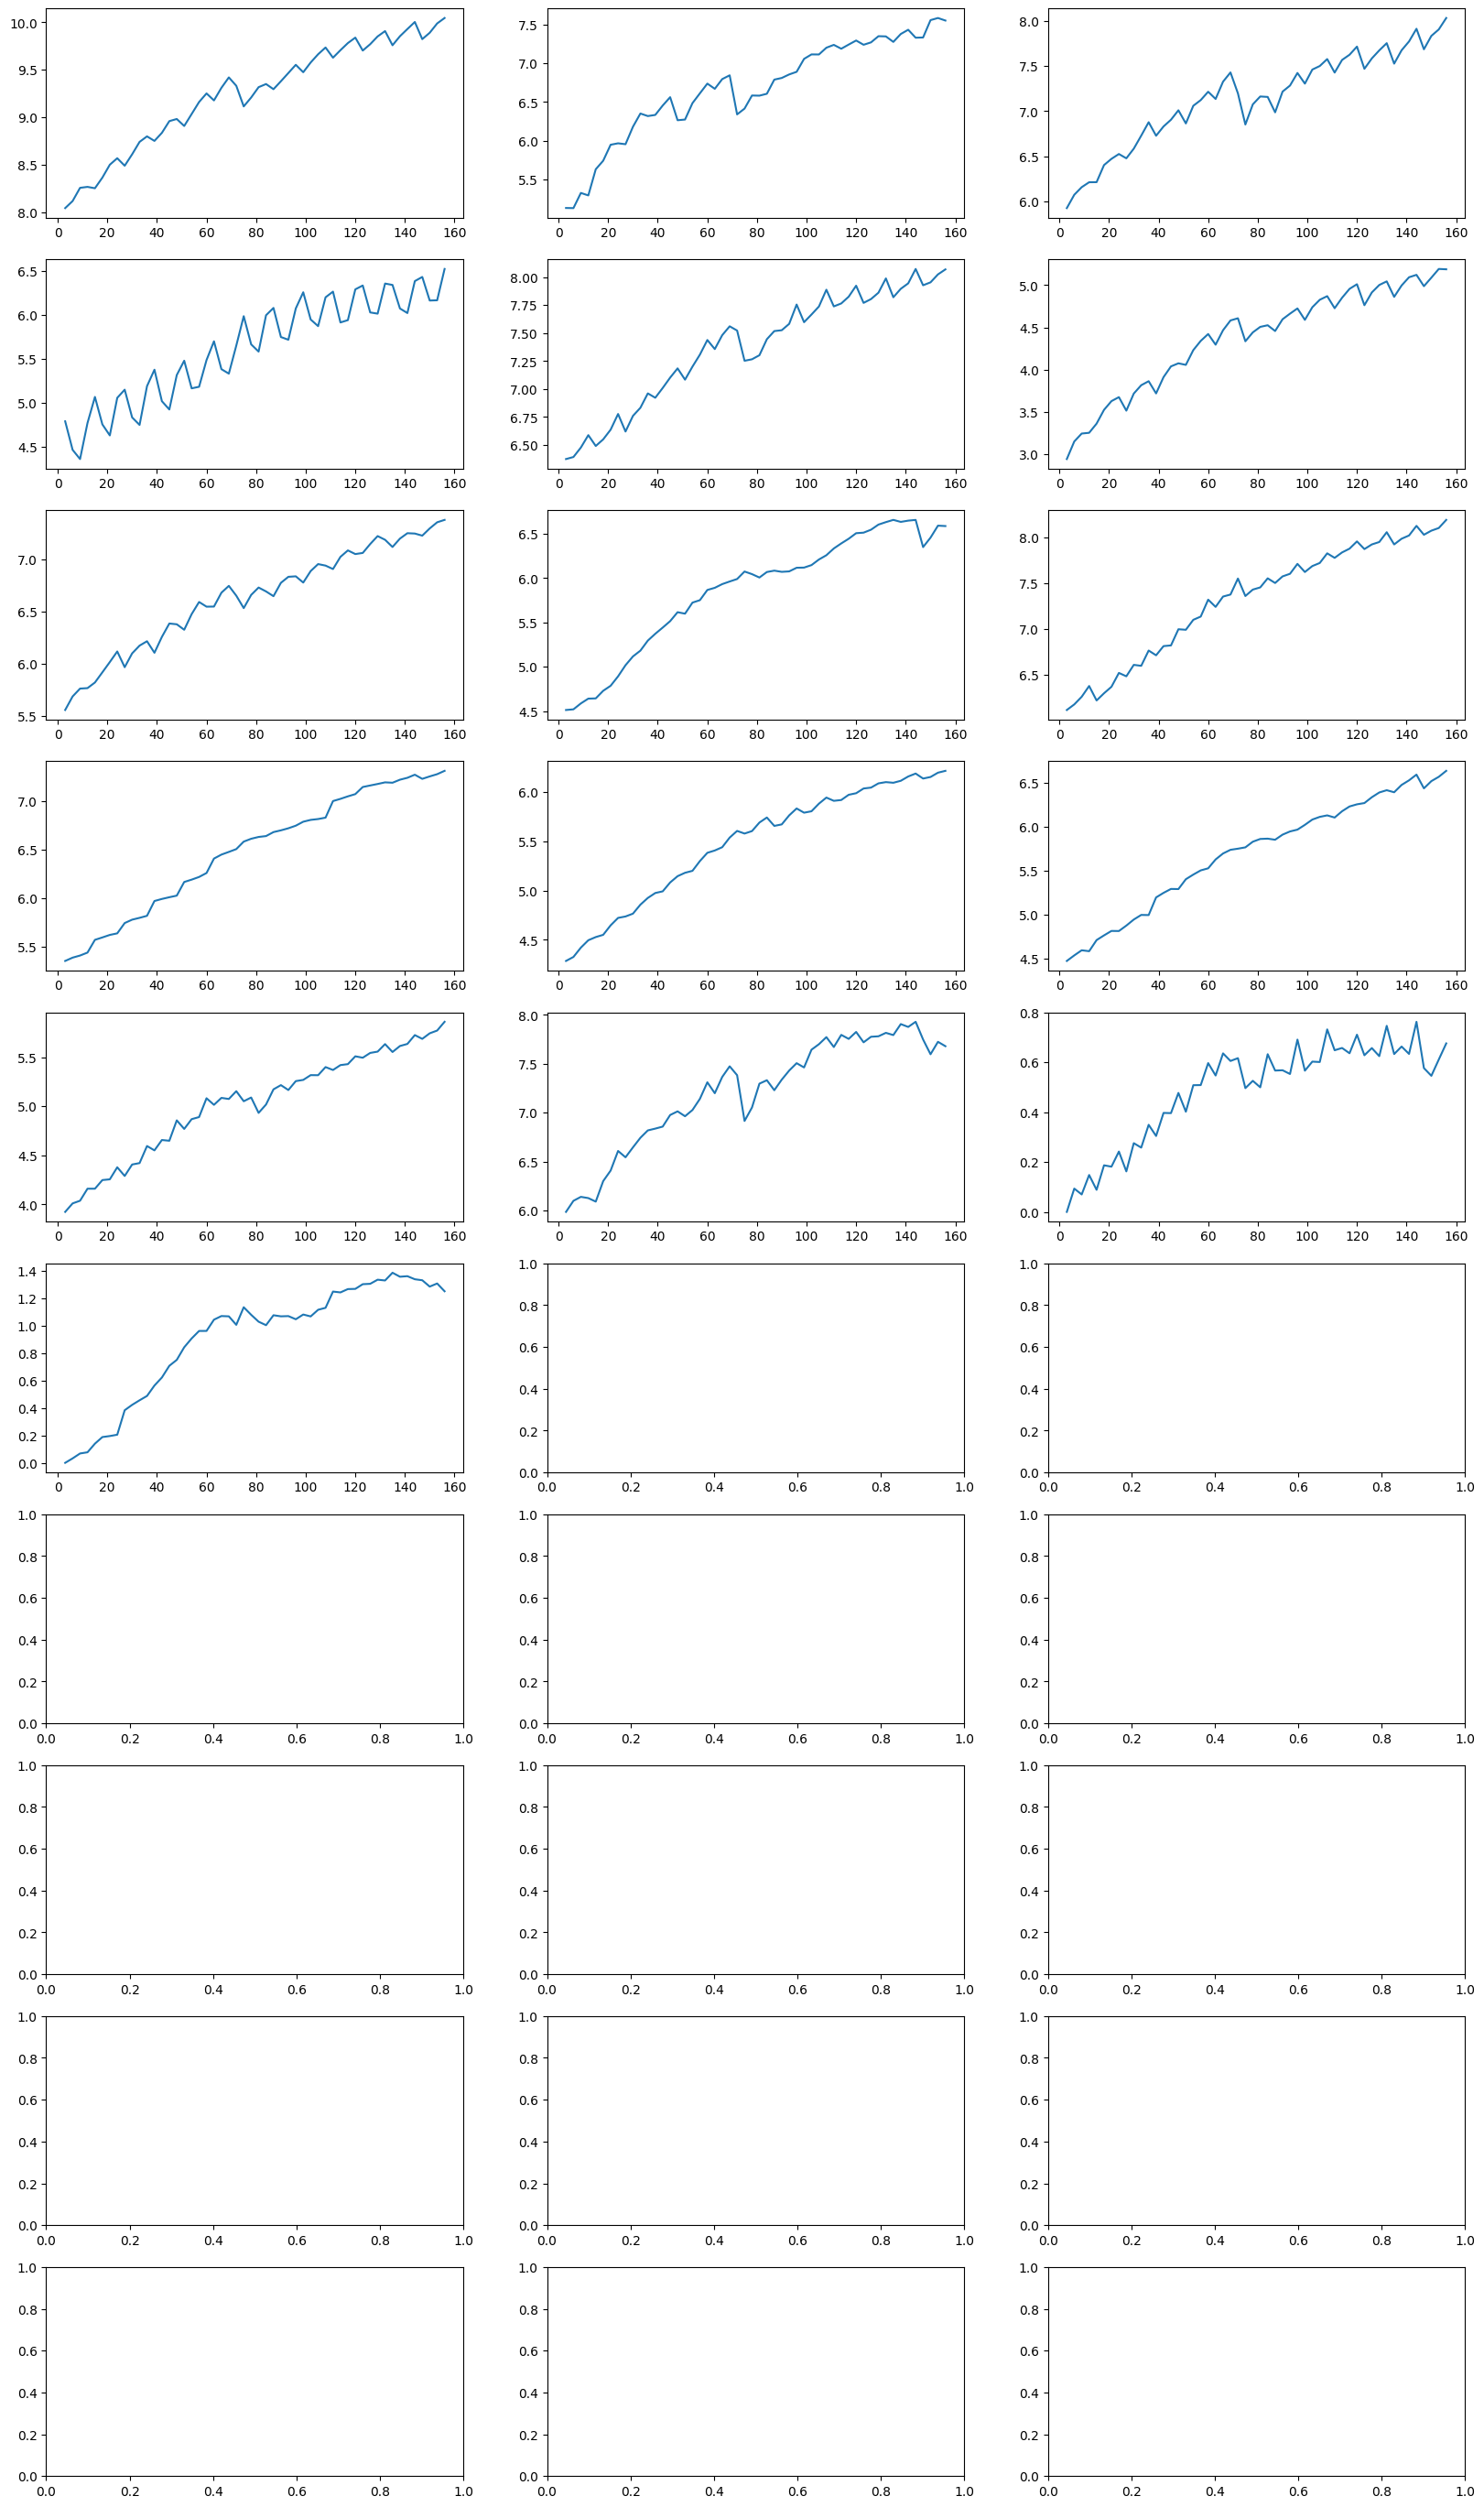

In [10]:
def my_plotter(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out

classes_quart = [cluster_table[cluster_table['class']==x].index.tolist() for x in cluster_table['class'].unique()]

fig, axes = plt.subplots(10, 3, figsize=(20, 35))

id = 0
for x in range(len(classes_quart[id])):

    axes[x//3][x%3].plot(train_quart_df['month_num'], train_quart_df[classes_quart[id][x]])

plt.show()